<a href="https://colab.research.google.com/github/efraimry/PredictFusion/blob/main/FraudDemandReco_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Keras Tuner jika belum ada
!pip install keras-tuner --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interact, IntSlider

sns.set_style('whitegrid')


In [ ]:
# Parameter
n_samples = 1000
seq_length = 5
n_features = 3

# Random feature data
X = np.random.rand(n_samples, seq_length, n_features)

# Target: fraud (0/1), demand (1-50), recommendation (0/1)
y_fraud = np.random.randint(0, 2, size=(n_samples, 1))
y_demand = np.random.randint(1, 51, size=(n_samples, 1))
y_reco = np.random.randint(0, 2, size=(n_samples, 1))

# Split train/test
train_size = int(0.8 * n_samples)
X_train, X_test = X[:train_size], X[train_size:]
y_fraud_train, y_fraud_test = y_fraud[:train_size], y_fraud[train_size:]
y_demand_train, y_demand_test = y_demand[:train_size], y_demand[train_size:]
y_reco_train, y_reco_test = y_reco[:train_size], y_reco[train_size:]

# Scale demand
scaler = MinMaxScaler()
y_demand_train_scaled = scaler.fit_transform(y_demand_train)
y_demand_test_scaled = scaler.transform(y_demand_test)


In [ ]:
def build_model(hp=None):
    inp = layers.Input(shape=(seq_length, n_features))
    x = layers.LSTM(32, return_sequences=False)(inp)
    x = layers.Dense(32, activation='relu')(x)

    # Output fraud
    fraud_out = layers.Dense(1, activation='sigmoid', name='fraud')(x)
    # Output demand
    demand_out = layers.Dense(1, activation='linear', name='demand')(x)
    # Output recommendation
    reco_out = layers.Dense(1, activation='sigmoid', name='reco')(x)

    model = keras.Model(inputs=inp, outputs=[fraud_out, demand_out, reco_out])
    model.compile(
        optimizer='adam',
        loss={'fraud':'binary_crossentropy',
              'demand':'mse',
              'reco':'binary_crossentropy'},
        metrics={'fraud':'accuracy','demand':'mse','reco':'accuracy'}
    )
    return model


In [ ]:
model = build_model()
history = model.fit(
    X_train,
    {'fraud': y_fraud_train, 'demand': y_demand_train_scaled, 'reco': y_reco_train},
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - demand_loss: 0.2677 - demand_mse: 0.2677 - fraud_accuracy: 0.4715 - fraud_loss: 0.6940 - loss: 1.6506 - reco_accuracy: 0.5482 - reco_loss: 0.6889 - val_demand_loss: 0.0980 - val_demand_mse: 0.0980 - val_fraud_accuracy: 0.5000 - val_fraud_loss: 0.6945 - val_loss: 1.5106 - val_reco_accuracy: 0.4437 - val_reco_loss: 0.7181
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - demand_loss: 0.0913 - demand_mse: 0.0913 - fraud_accuracy: 0.4832 - fraud_loss: 0.6970 - loss: 1.4845 - reco_accuracy: 0.5209 - reco_loss: 0.6962 - val_demand_loss: 0.0954 - val_demand_mse: 0.0954 - val_fraud_accuracy: 0.5000 - val_fraud_loss: 0.6940 - val_loss: 1.5007 - val_reco_accuracy: 0.4437 - val_reco_loss: 0.7113
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - demand_loss: 0.0945 - demand_mse: 0.0945 - fraud_accuracy: 0.4850 - fraud_loss: 0.6942 - loss: 1.4795 - reco_accuracy: 0.5335 - reco_loss: 0.6908 - val_demand_loss: 0.0943 - val_demand_mse: 0.0943 

In [ ]:
# Ambil 200 sample
n_samples_display = 200
sample_df = pd.DataFrame(X_test[:n_samples_display].reshape(n_samples_display, seq_length*n_features),
                         columns=[f'feat{i+1}' for i in range(seq_length*n_features)])

# Label asli
sample_df['fraud_actual'] = y_fraud_test[:n_samples_display].flatten()
sample_df['demand_actual'] = y_demand_test[:n_samples_display].flatten()
sample_df['reco_actual'] = y_reco_test[:n_samples_display].flatten()

# Prediksi
fraud_pred, demand_pred, reco_pred = model.predict(X_test[:n_samples_display])
fraud_label = (fraud_pred > 0.5).astype(int)
reco_label = (reco_pred > 0.5).astype(int)
demand_pred_original = scaler.inverse_transform(demand_pred)

sample_df['fraud_pred_prob'] = np.round(fraud_pred.flatten(),2)
sample_df['fraud_pred_label'] = fraud_label.flatten()
sample_df['demand_pred'] = np.round(demand_pred_original.flatten(),2)
sample_df['reco_pred_prob'] = np.round(reco_pred.flatten(),2)
sample_df['reco_pred_label'] = reco_label.flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [ ]:
def dashboard_interactive(start=0, end=50):
    df = sample_df[start:end]

    # Fraud vs Non-Fraud
    plt.figure(figsize=(6,3))
    sns.countplot(x='fraud_pred_label', data=df)
    plt.xticks([0,1], ['Non-Fraud','Fraud'])
    plt.title(f'Fraud vs Non-Fraud (Transaksi {start}-{end})')
    plt.show()

    # Distribusi Demand
    plt.figure(figsize=(6,3))
    sns.histplot(df['demand_pred'], bins=15, kde=True, color='blue')
    plt.title(f'Distribusi Prediksi Demand (Transaksi {start}-{end})')
    plt.xlabel('Jumlah Produk')
    plt.show()

    # Rekomendasi vs Fraud
    plt.figure(figsize=(6,3))
    sns.countplot(x='reco_pred_label', hue='fraud_pred_label', data=df)
    plt.xticks([0,1], ['No Recommendation','Recommendation'])
    plt.title(f'Rekomendasi Produk vs Fraud (Transaksi {start}-{end})')
    plt.legend(title='Fraud Prediksi', labels=['Non-Fraud','Fraud'])
    plt.show()

    # Tabel sample
    display(df[['fraud_actual','fraud_pred_prob','fraud_pred_label',
                'demand_actual','demand_pred',
                'reco_actual','reco_pred_prob','reco_pred_label']])


In [ ]:
interact(dashboard_interactive,
         start=IntSlider(min=0, max=n_samples_display-10, step=10, value=0),
         end=IntSlider(min=10, max=n_samples_display, step=10, value=50));


interactive(children=(IntSlider(value=0, description='start', max=190, step=10), IntSlider(value=50, descripti…

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_dashboard(fraud_true, fraud_pred_prob, demand_true, demand_pred_scaled, reco_true, reco_pred_prob):
    # ===== Fraud Evaluation =====
    fraud_pred_label = (fraud_pred_prob > 0.5).astype(int)
    cm_fraud = confusion_matrix(fraud_true, fraud_pred_label)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_fraud, annot=True, fmt='d', cmap='Blues')
    plt.title("Fraud Detection Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ===== Recommendation Evaluation =====
    reco_pred_label = (reco_pred_prob > 0.5).astype(int)
    cm_reco = confusion_matrix(reco_true, reco_pred_label)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_reco, annot=True, fmt='d', cmap='Greens')
    plt.title("Product Recommendation Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ===== Demand Evaluation =====
    demand_pred_original = scaler.inverse_transform(demand_pred_scaled)
    errors = demand_true - demand_pred_original.flatten()

    plt.figure(figsize=(6,4))
    sns.histplot(errors, bins=20, kde=True, color='orange')
    plt.title("Demand Prediction Error Distribution")
    plt.xlabel("Error (Actual - Predicted)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.scatter(demand_true, demand_pred_original, alpha=0.6, color='purple')
    plt.plot([demand_true.min(), demand_true.max()],
             [demand_true.min(), demand_true.max()], 'r--')
    plt.title("Demand Prediction: Actual vs Predicted")
    plt.xlabel("Actual Demand")
    plt.ylabel("Predicted Demand")
    plt.show()

    # Print summary metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
    print("=== Fraud Metrics ===")
    print(f"Accuracy: {accuracy_score(fraud_true, fraud_pred_label):.2f}")
    print(f"Precision: {precision_score(fraud_true, fraud_pred_label):.2f}")
    print(f"Recall: {recall_score(fraud_true, fraud_pred_label):.2f}")
    print(f"F1-Score: {f1_score(fraud_true, fraud_pred_label):.2f}")

    print("\n=== Recommendation Metrics ===")
    print(f"Accuracy: {accuracy_score(reco_true, reco_pred_label):.2f}")
    print(f"Precision: {precision_score(reco_true, reco_pred_label):.2f}")
    print(f"Recall: {recall_score(reco_true, reco_pred_label):.2f}")
    print(f"F1-Score: {f1_score(reco_true, reco_pred_label):.2f}")

    print("\n=== Demand Metrics ===")
    mse = mean_squared_error(demand_true, demand_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(demand_true, demand_pred_original)
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


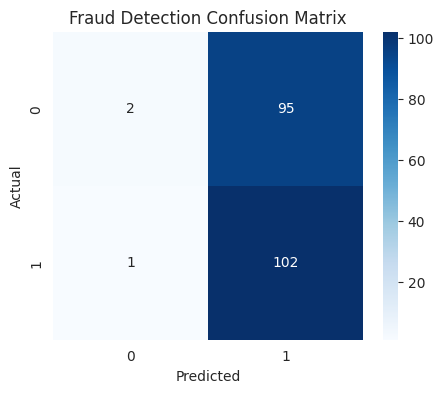

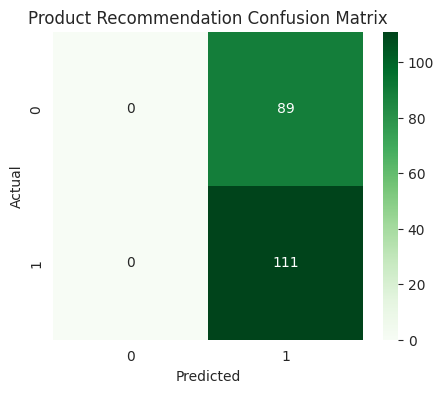

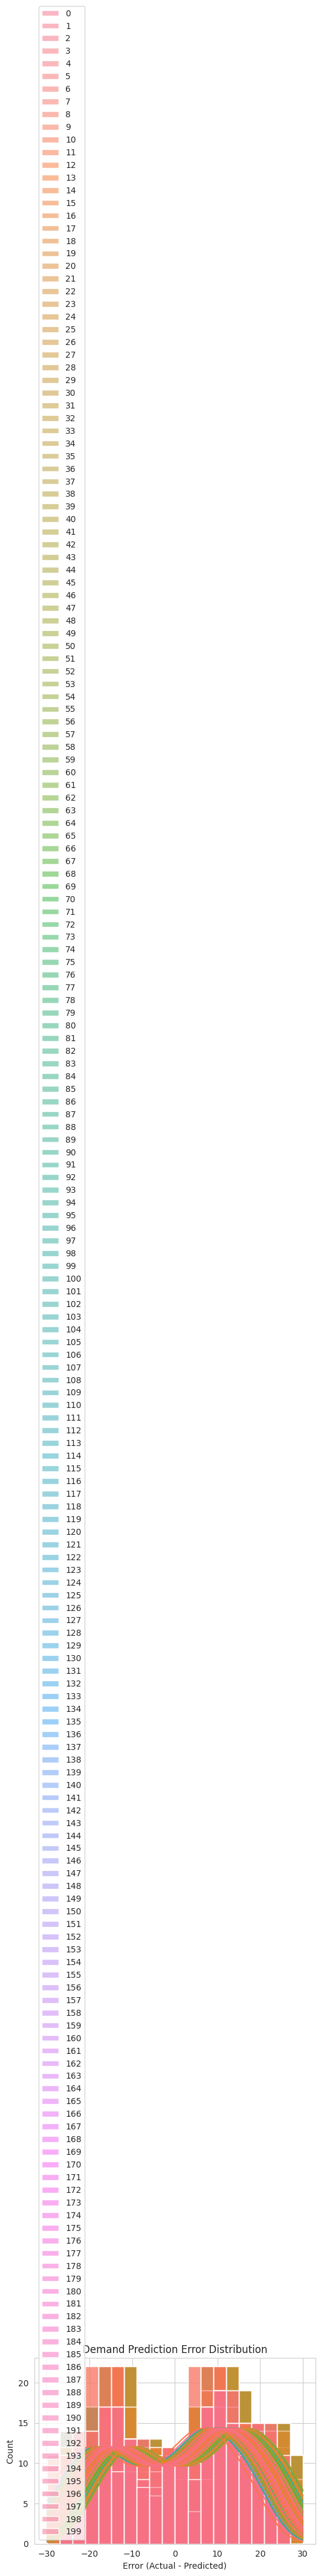

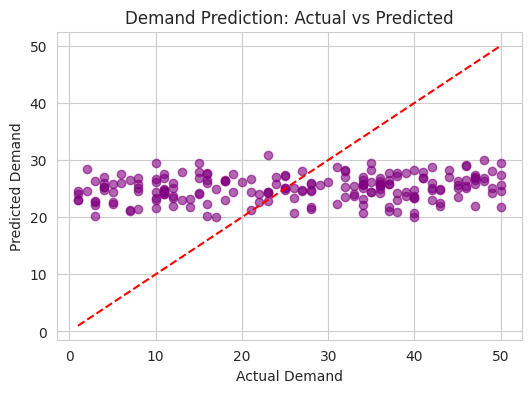

=== Fraud Metrics ===
Accuracy: 0.52
Precision: 0.52
Recall: 0.99
F1-Score: 0.68

=== Recommendation Metrics ===
Accuracy: 0.56
Precision: 0.56
Recall: 1.00
F1-Score: 0.71

=== Demand Metrics ===
MSE: 208.68, RMSE: 14.45, MAE: 12.76


In [ ]:
evaluate_dashboard(
    fraud_true = y_fraud_test[:n_samples_display],
    fraud_pred_prob = fraud_pred,
    demand_true = y_demand_test[:n_samples_display],
    demand_pred_scaled = demand_pred,
    reco_true = y_reco_test[:n_samples_display],
    reco_pred_prob = reco_pred
)
